In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', None)

import re

import seaborn as sea
import matplotlib.pyplot as plt

from nanoporePipelineCommon import *

print("imports done")

imports done


In [2]:
reads_df_genes_raw, compressed_df_genes_raw = load_and_merge_lib_parquets(["xrn-1-5tera", "xrn-1-5tera-smg-6"], drop_sub_n=1, add_tail_groupings=False, drop_failed_polya=False, group_by_t5=True)
print("library load done.")

Loading readAssignments file from: /data16/marcus/genomes/elegansRelease100/Caenorhabditis_elegans.WBcel235.100.allChrs.parquet... Done.
Looking for files for libraries: ['xrn-1-5tera', 'xrn-1-5tera-smg-6']
Looking for file for xrn-1-5tera, at /data16/marcus/working/211118_nanoporeRun_totalRNA_5108_xrn-1-KD_5TERA/output_dir/merge_files/*_mergedOnReads.parquet... File Found.
Looking for file for xrn-1-5tera-smg-6, at /data16/marcus/working/211210_nanoporeRun_totalRNA_2102_xrn-1-KD_5TERA/output_dir/merge_files/*_mergedOnReads.parquet... File Found.
Loading parquet for xrn-1-5tera lib... Done.
'original_chr_pos' column already found in dataframe, skipping adjustment for 5'ends!
Loading parquet for xrn-1-5tera-smg-6 lib... Done.
'original_chr_pos' column already found in dataframe, skipping adjustment for 5'ends!
Finished assignment merge!. . .
Read counts post gene assignment:  937835
Read counts post unassigned drop:  636409
Creating groupby dataframe merged on: ['lib', 'chr_id', 'gene_i

Counting reads per gene: 100%|██████████| 31278/31278 [00:00<00:00, 65044.15it/s]


Gene counts pre sub-1 gene_hits drop:  31278
Gene counts post sub-1 gene_hits drop:  31278
library load done.


In [3]:
reads_df = reads_df_genes_raw.copy()
compressed_df = compressed_df_genes_raw.copy()

In [42]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

def make_rectangle_patch(genome_start, length, y_center, thickness, color='gray'):
    return Rectangle((genome_start, y_center-(thickness/2)), length, thickness,
                     facecolor=color,
                     edgecolor=color,
                     fill=True,
                     lw=0)

def plot_cigar_and_genome_start(axes, cigar, gen_start, y, color='black', tail_length=None):
    # Parse the cigar string
    parsed_cigar = re.findall(rf'(\d+)([MDNSIX])', cigar)
    mdn_nums = [int(num) for num, char in parsed_cigar if char in "MDN"]
    read_end = gen_start + sum(mdn_nums)
    
    genome_loc = gen_start
    
    rectangle_patch_list = []
    first_n_length = None
    for length, code in parsed_cigar:
        length = int(length)
        if code == 'S':
            if len(rectangle_patch_list) == 0:
                # genome_loc += length  # <- this was dumb and wrong...
                pass
        elif code == 'M':
            rectangle_patch_list.append(make_rectangle_patch(genome_loc, length, y, thickness=0.8))
            genome_loc += length
        elif code == 'D':
            if length < 50:
                rectangle_patch_list.append(make_rectangle_patch(genome_loc, length, y, thickness=0.8))
            else:
                rectangle_patch_list.append(make_rectangle_patch(genome_loc, length, y, thickness=0.001))
            genome_loc += length
        elif code == 'I':
            pass
        elif code == 'N':
            if not first_n_length:
                first_n_length = length
                # print(f"First N of length {length}, starting at {genome_loc}")
            rectangle_patch_list.append(make_rectangle_patch(genome_loc, length, y, thickness=0.001))
            genome_loc += length
    if read_end - gen_start < 1500:
        axes.add_collection(PatchCollection(rectangle_patch_list, color=color))
        if isinstance(tail_length, float):
            axes.add_patch(make_rectangle_patch(genome_loc, tail_length, y, thickness=0.4, color='green'))
            genome_loc += tail_length
        return read_end - gen_start, first_n_length
    else:
        return None

def row_apply_plot_cigar(row, axes):
    index = row.name
    cigar = row.cigar
    gen_start = row.chr_pos
    is_adapted = row.t5
    polya_length = row.polya_length
    
    if is_adapted == '-':
        color='black'
    else:
        color='red'
    return plot_cigar_and_genome_start(axes, cigar, gen_start, index, color=color, tail_length=polya_length)

In [59]:
def plot_reads(gene_of_interest, reads_df, save_dir=None, save_suffix="", t5_pos_count=10, t5_neg_count=25, plot_width_and_height=(25,5)):
    all_gene_reads = reads_df.query(f"gene_name == '{gene_of_interest}'")
    gene_df_t5_pos = all_gene_reads.query("t5 == '+'").sample(t5_pos_count)
    gene_df_t5_neg = all_gene_reads.query("t5 == '-'").sample(t5_neg_count)
    gene_df = pd.concat([gene_df_t5_pos, gene_df_t5_neg])
    
    gene_df = gene_df.sort_values(["t5", "chr_pos", "read_length"], ascending=False).reset_index(drop=True)
    
    plt.style.use('default')
    fig, ax = plt.subplots()
    tqdm.pandas(desc="First pass to extract the length of the first intron called")
    gene_df[['genomic_read_length', 'first_n_length']] = gene_df.progress_apply(lambda row: row_apply_plot_cigar(row, ax), axis=1, result_type='expand')
    fig, ax = None, None
    
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=plot_width_and_height)
    
    tqdm.pandas(desc="Second pass to actually plot everything")
    gene_df = gene_df.sort_values(["t5", "first_n_length", "chr_pos"], ascending=[False, False, False]).reset_index(drop=True)
    gene_df.progress_apply(lambda row: row_apply_plot_cigar(row, ax), axis=1, result_type='expand')

    
    
    
    number_of_plotted_reads = gene_df.shape[0]
    ax.set_ylim(-1, number_of_plotted_reads)
    
    if number_of_plotted_reads < 50:
        num_long_reads_to_check = 1
    else:
        num_long_reads_to_check = int(number_of_plotted_reads/10)
    
    min_genomic_start = gene_df.chr_pos.min()
    max_genomic_length = gene_df.nlargest(num_long_reads_to_check, 'genomic_read_length').genomic_read_length.min()
    
    ax.set_xlim(min_genomic_start-25, min_genomic_start+max_genomic_length+100)
    # ax.set_xlim(min_genomic_start, min_genomic_start+300)
    
    plt.xticks([])
    plt.yticks([])
    if isinstance(save_dir, str):
        save_path = f"{save_dir}/{get_dt(for_file=True)}_{gene_of_interest}{save_suffix}"
        print(f"Saving plot to {save_path} + .png/.svg...")
        plt.savefig(save_path + ".svg")
        plt.savefig(save_path + ".png")
    plt.show()
    return gene_df

First pass to extract the length of the first intron called: 100%|██████████| 35/35 [00:00<00:00, 282.75it/s]
Second pass to actually plot everything: 100%|██████████| 35/35 [00:00<00:00, 286.56it/s]


Saving plot to ./220524_ubl-1_wt_1 + .png/.svg...


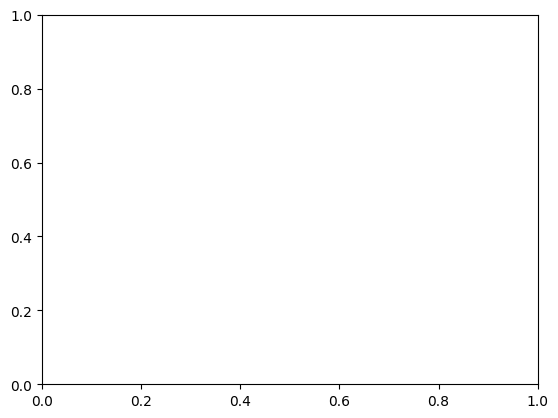

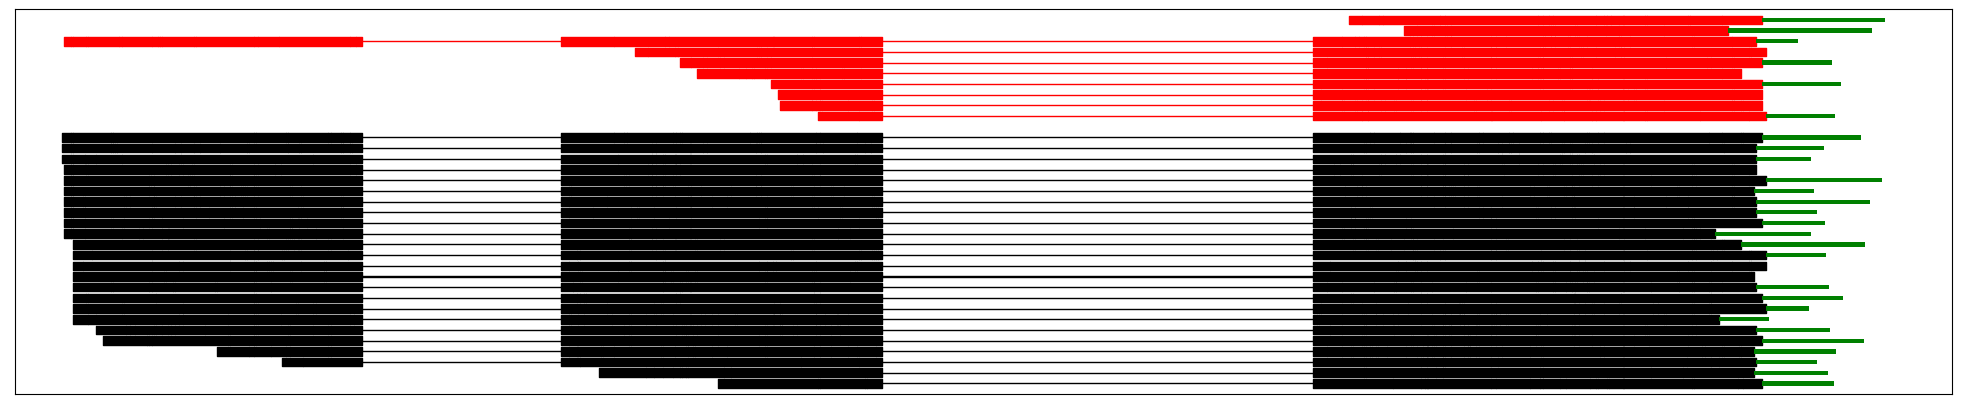

First pass to extract the length of the first intron called: 100%|██████████| 27/27 [00:00<00:00, 272.99it/s]
Second pass to actually plot everything: 100%|██████████| 27/27 [00:00<00:00, 277.87it/s]


Saving plot to ./220524_ubl-1_smg-6_1 + .png/.svg...


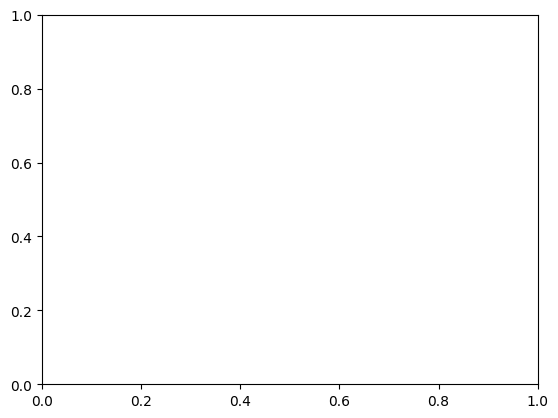

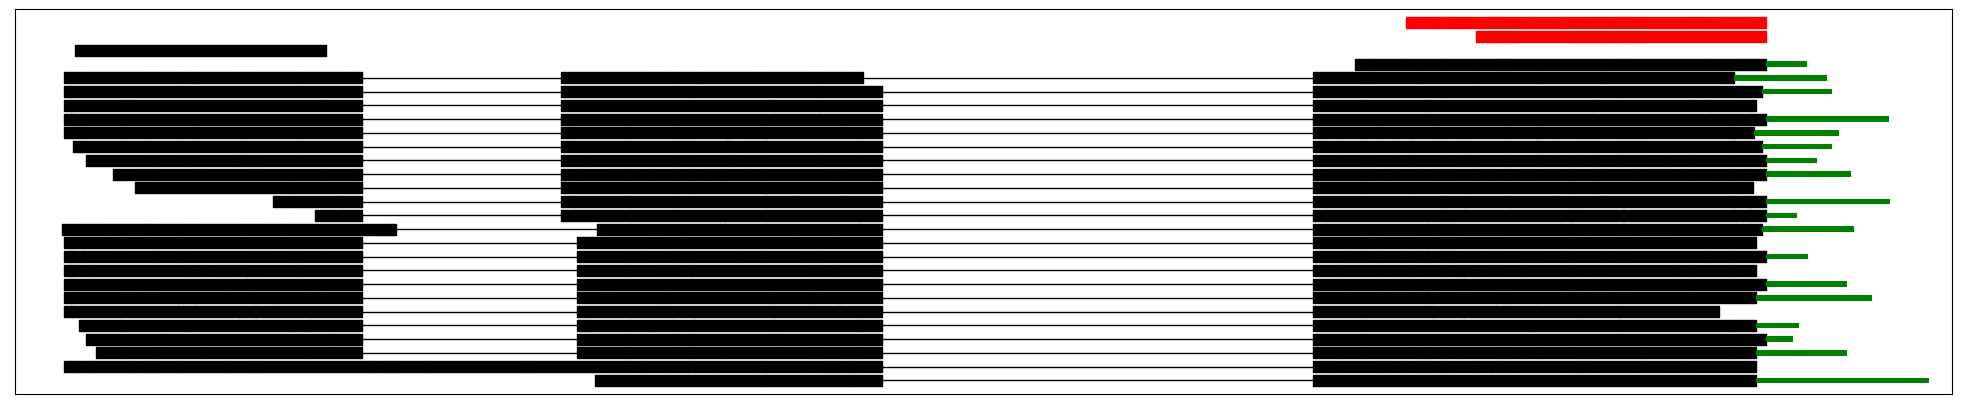

First pass to extract the length of the first intron called: 100%|██████████| 35/35 [00:00<00:00, 70.64it/s] 
Second pass to actually plot everything: 100%|██████████| 35/35 [00:00<00:00, 305.83it/s]


Saving plot to ./220524_ubl-1_wt_2 + .png/.svg...


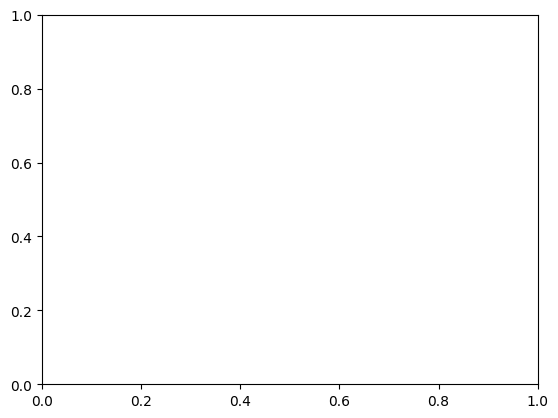

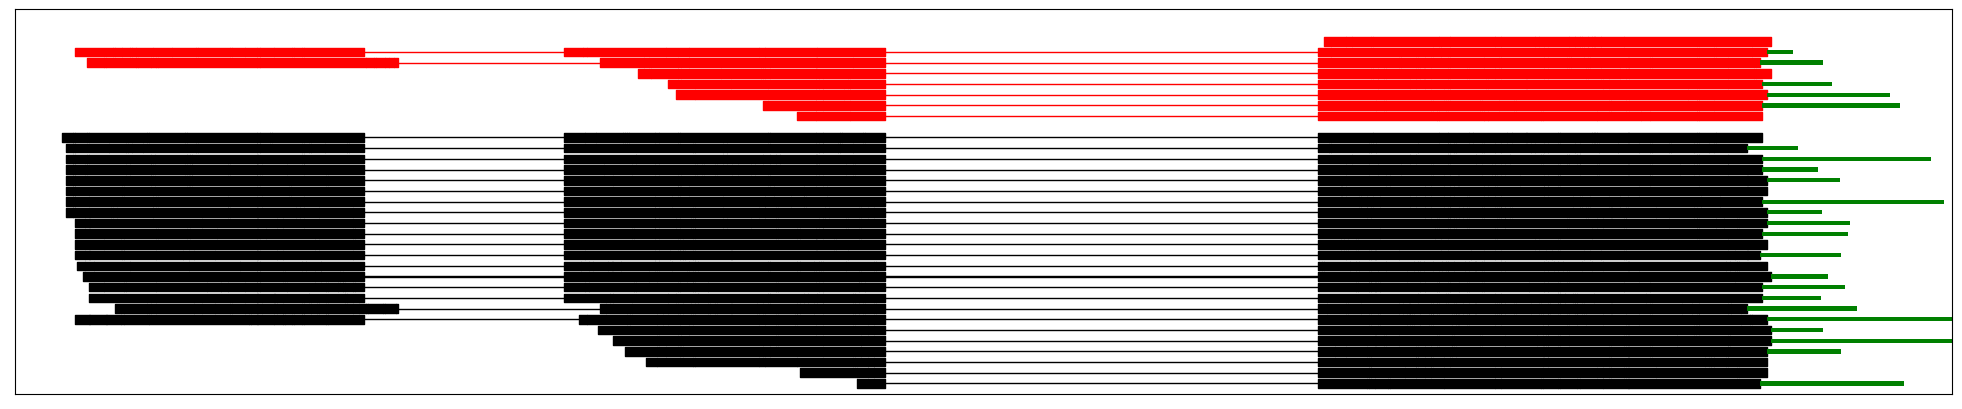

First pass to extract the length of the first intron called: 100%|██████████| 27/27 [00:00<00:00, 247.08it/s]
Second pass to actually plot everything: 100%|██████████| 27/27 [00:00<00:00, 243.66it/s]


Saving plot to ./220524_ubl-1_smg-6_2 + .png/.svg...


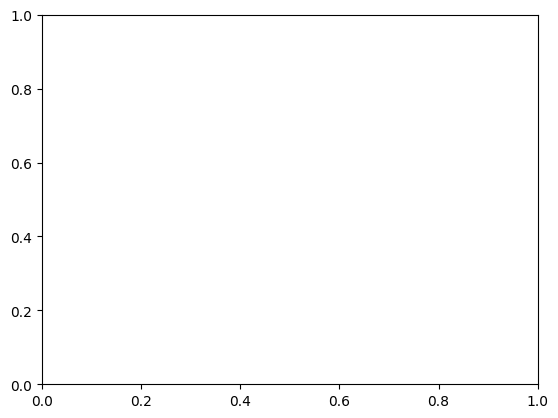

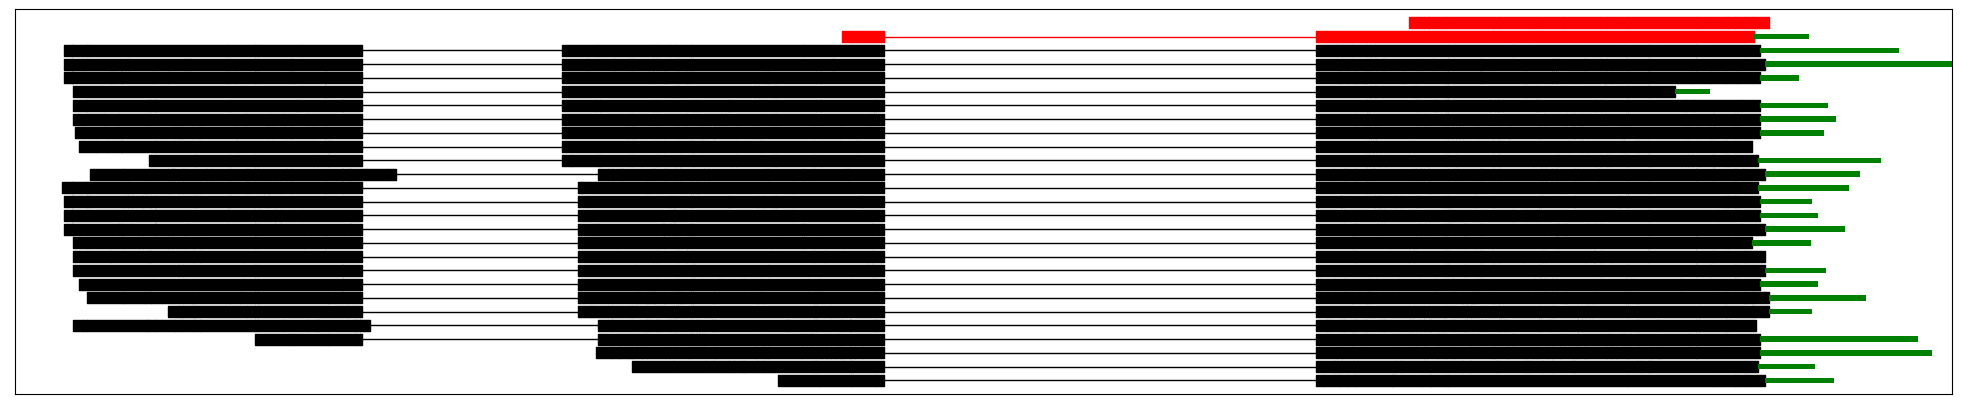

In [60]:
for i in range(2):
    df1 = plot_reads("ubl-1", reads_df.query("lib == 'xrn-1-5tera'"), save_dir=".", save_suffix=f"_wt_{i+1}")
    df2 = plot_reads("ubl-1", reads_df.query("lib != 'xrn-1-5tera'"), save_dir=".", save_suffix=f"_smg-6_{i+1}", t5_pos_count=2)